# Citywide Cellular Traffic Prediction Based on Densely Connected Convolutional Neural Networks 
## —— Dataset Analyse and Preprocess

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #空间三维画图
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from matplotlib.animation import FFMpegWriter

## Dataset

Dataset:
the telecommunication activity in the city of Milan and in the Province of Trentino.
* paper: A multi-source dataset of urban life in the city of Milan and the Province of Trentino
* src: https://doi.org/10.7910/DVN/EGZHFV
* Format: 
    - Square id
    - Time Interval
    - Country code
    - SMS-in activity
    - SMS-out activity
    - Call-in activity
    - Call-out activity
    - Internet traffic activity

In [2]:
data = []
Days = 2

for i in range(4, 4+Days):
    if i == 4:
        data = pd.read_csv("sms-call-internet-mi-2013-11-" + str(i).rjust(2, '0') + ".txt",header=None, sep = '\t')
    else:
        data = pd.concat([data, pd.read_csv("sms-call-internet-mi-2013-11-" + str(i).rjust(2, '0') + ".txt",header=None, sep = '\t')])
    
data.columns = ['SquareID', 'Time', 'CountryCode', 'SMSIn', 'SMSOut', 'CallIn', 'CallOut', 'Internet']
data = data.fillna(0)
valueIndex = ['SMSIn', 'SMSOut', 'CallIn', 'CallOut', 'Internet']

In [6]:
dataTmp = data.groupby(['SquareID', 'Time'])
dataTmp = dataTmp['SMSOut'].sum()

SpatialTemporalMat = np.zeros([Days * 24 * 6, 100, 100])
timeStart = 1383519600000

for i,j in dataTmp.index:
    t = int((j - 1383519600000) / 600000)
    x = int((i-1) / 100)
    y = int((i-1) % 100)
    SpatialTemporalMat[t,x,y] = dataTmp[i,j]

Vedio Generation of Test Result 

In [9]:
[X, Y] = np.meshgrid(np.arange(100), np.arange(100)) 

writer = FFMpegWriter(
    fps=15, metadata=dict(title='01', artist='Matplotlib',comment='depth prediiton')
)
fig = plt.figure(figsize=(10, 10))
plt.ion()
fig.tight_layout()

with writer.saving(fig, "writer_test.mp4", 100):
    for i in range(0, Days*6*24):
        ax = fig.add_subplot(projection='3d')
        ax.set_zlim(zmin = 0, zmax = 50)
        ax.plot_surface(X, Y, data2[i,:,:] ,cmap='viridis', edgecolor='none', facecolor='w')

        writer.grab_frame()
        plt.clf()

<Figure size 720x720 with 0 Axes>

## Dataset Analyse -- Spatial & Temporal Features

Spatial Distribution

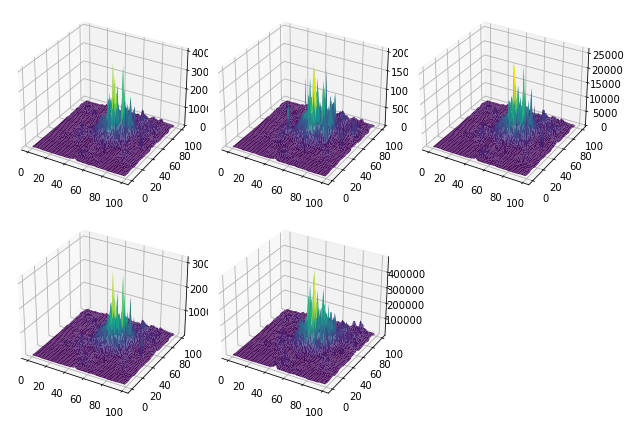

In [3]:
dataTmp = data.groupby(['SquareID'])
fig = plt.figure(figsize = (8.5, 6))

for i in range(np.size(valueIndex)):
    spatialDistribution = dataTmp[valueIndex[i]].sum().sort_index()
    spatialDistribution = np.array(spatialDistribution).reshape(100,100)

    [X, Y] = np.meshgrid(np.arange(np.size(spatialDistribution,1)), np.arange(np.size(spatialDistribution,0))) 
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    ax.plot_surface(X, Y, spatialDistribution,cmap='viridis', edgecolor='none')
    
fig.tight_layout()

Temporal Distribution

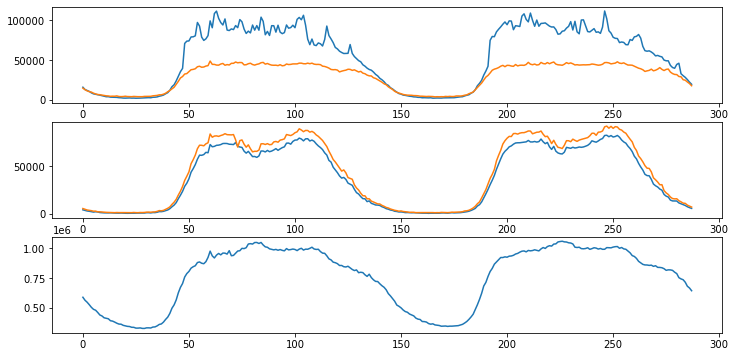

In [15]:
dataTmp = data.groupby(['Time'])
fig, ax = plt.subplots(3, 1, figsize = (12, 6))

for i in range(np.size(valueIndex)):
    temporalDistribution = dataTmp[valueIndex[i]].sum().sort_index()
    temporalDistribution = np.array(temporalDistribution)

    if(i<2):
        ax[0].plot(temporalDistribution)
    elif(i<4):
        ax[1].plot(temporalDistribution)
    else:
        ax[2].plot(temporalDistribution)

Spatial & Temporal Correlation

## Dataset Preprocess

$\Delta t:$10 min $\to$ 1 hour

In [10]:
SpatialTemporalMat2 = np.zeros([Days * 24, 100, 100])

for i in range(0, np.size(SpatialTemporalMat, 0), 6):
    SpatialTemporalMat2[int(i/6), :, :] = SpatialTemporalMat[i:i+6, :, :].sum(0)

[[101.42804717 102.89412759 104.4547122  ... 101.69542144 101.62039172
  101.5944758 ]
 [103.15296342 103.12692856 104.4547122  ... 101.62039172 101.62039172
  101.62281773]
 [103.67018541 101.41445761 104.45726397 ... 101.62039172 101.65139142
  101.99935499]
 ...
 [106.68221364 121.69946209 116.21265954 ... 345.66662458 358.97506389
  272.52046565]
 [113.72708548 121.69355188 121.69946209 ... 322.35932464 268.58399882
  295.51231374]
 [119.59515255 121.51219716 121.69946209 ... 363.56983428 269.03829594
  258.72139709]]


### Min-Max Normalization
scale data to range [0, 1]

In [21]:
def MinMaxNorm01(x):
    minn = x.min()
    maxn = x.max()
    return 1.0 * (x - minn) / (maxn - minn)

SpatialTemporalMat3 = MinMaxNorm01(SpatialTemporalMat2)

0.0


Save Data as File

In [22]:
np.save('DataSet.npy', SpatialTemporalMat3)